In [1]:
import os
import pathlib
import nltk
import numpy as np
from unicodedata import normalize
import collections


nltk.download('words')


[nltk_data] Downloading package words to /home/filipp/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
path_data = 'data-simplification/wikilarge/wiki.full.aner.'

In [3]:
train_src = open(path_data+'train.src', "r").readlines()
train_dst = open(path_data+'train.dst', "r").readlines()
train_ori_src = open(path_data+'ori.train.src', "r").readlines()
train_ori_dst = open(path_data+'ori.train.dst', "r").readlines()

valid_src = open(path_data+'valid.src', "r").readlines()
valid_dst = open(path_data+'valid.dst', "r").readlines()
valid_ori_src = open(path_data+'ori.valid.src', "r").readlines()
valid_ori_dst = open(path_data+'ori.valid.dst', "r").readlines()

### Comparison of datasets; will work with original first. Named entity identification is applied to get the modified dataset. Might facilitate trainining working with this.

In [4]:
train_src[114]

'ORGANIZATION@1 crews conducted backburning operations to ensure containment of the fire on NUMBER@1 February , warning residents of areas between LOCATION@1 and Warragul about smoke from those fires .\n'

In [5]:
train_ori_src[114]

'DSE crews conducted backburning operations to ensure containment of the fire on 9 February , warning residents of areas between Pakenham and Warragul about smoke from those fires .\n'

In [6]:
train_ori_dst[114]

'People between Pakenham and Warragul were warned about smoke from those fires .\n'

In [7]:
train_dst[114]

'People between LOCATION@1 and Warragul were warned about smoke from those fires .\n'

In [8]:
valid_ori_dst[11]

'Thousands of young people from all over the world went to San Francisco to help create a hippie counterculture . The Summer of Love made the rest of America much more aware of the hippie movement .\n'

In [9]:
def ie_preprocess(document):
    sentences = nltk.sent_tokenize(document) 
    sentences = [nltk.word_tokenize(sent) for sent in sentences] 
    sentences = [nltk.pos_tag(sent) for sent in sentences] 
    return sentences


In [10]:
embedding_index = {}
file = os.path.join(str(pathlib.Path.home())+"/GloVe","glove.6B.100d.txt")
f= open(file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs



### A glimpse at the representations.

In [11]:
i = 0
for key, value in embedding_index.items():
    if i>5:
        break
    print(key, value)
    print(value.shape)
    i += 1

the [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

In [12]:
def clean(sentences): 
    clean_txt = ''
    for line in sentences:        

        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # tokenize on white space
        line = line.split()
        # convert to lowercase
        line = [word.lower() for word in line]
        # remove punctuation from each token
        #line = [word.translate(table) for word in line]
        # remove non-printable chars form each token
        #line = [re_print.sub('', w) for w in line]
        # remove tokens with numbers in them
        line = [word for word in line if word.isalpha()]
        # store as string
        clean_txt += (' '.join(line))
    return clean_txt

In [13]:
clean_txt = clean(train_ori_src)

In [14]:
train_ori_src[0:2]

["There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .\n",
 "In a remarkable comparative analysis , Mandaean scholar Säve-Söderberg demonstrated that Mani 's Psalms of Thomas were closely related to Mandaean texts .\n"]

In [15]:
clean_txt[0:400]

'there is manuscript evidence that austen continued to work on these pieces as late as the period a and that her niece and nephew anna and james edward austen made further additions as late asin a remarkable comparative analysis mandaean scholar demonstrated that mani psalms of thomas were closely related to mandaean textsbefore persephone was released to hermes who had been sent to retrieve her ha'

In [16]:
token_list_src = nltk.word_tokenize(clean_txt)
print(token_list_src[0:20],"\n")
print("Total tokens : ", len(token_list_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that'] 

Total tokens :  5742368


In [17]:
# comparison with source tokens when entities replaced by placeholders
token_list_with_ent_src = nltk.word_tokenize(clean(train_src))
print(token_list_with_ent_src[0:20],"\n")
print("Total tokens : ", len(token_list_with_ent_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that', 'her'] 

Total tokens :  4961048


In [18]:
#total vocabulary size in source
len(set(token_list_src))

332341

### Looking at the frequencies

In [19]:
token_list_src_Counter = collections.Counter(token_list_src)

In [21]:
#most common vocabulary
token_list_src_Counter.most_common(20)

[('the', 414529),
 ('of', 238408),
 ('and', 180703),
 ('in', 180597),
 ('a', 158684),
 ('is', 116580),
 ('to', 102777),
 ('was', 61810),
 ('as', 55788),
 ('by', 45144),
 ('for', 44558),
 ('on', 41885),
 ('with', 36286),
 ('from', 30777),
 ('that', 29024),
 ('an', 28936),
 ('or', 28105),
 ('are', 25374),
 ('at', 23806),
 ('his', 21935)]

In [22]:
#list out of Counter
token_list_src_Counter_desc = []
for key, value in token_list_src_Counter.items():
    token_list_src_Counter_desc.append((value, key))

In [23]:
#print least common
print(len(token_list_src_Counter_desc))
token_list_src_Counter_desc[-20:]

332341


[(1, 'statesshade'),
 (1, 'homelandhe'),
 (1, 'andhabilis'),
 (1, 'praiseit'),
 (1, 'europeavars'),
 (1, 'judthe'),
 (1, 'pragmaticis'),
 (1, 'bisnaga'),
 (1, 'plateaunathan'),
 (1, 'grandchildrenafter'),
 (1, 'wickboro'),
 (1, 'wced'),
 (1, 'mainlandwhile'),
 (1, 'foolishly'),
 (1, 'himprinted'),
 (1, 'bookbarbirolli'),
 (1, 'archivedle'),
 (1, 'francetijs'),
 (1, 'januaryoperationally'),
 (1, 'cyclonethese')]

In [24]:
embedding_size = 100 # GloVe 100d
threshold = 4
token_list_src_over_threshold = [(count, word) for (count, word) in token_list_src_Counter_desc if count > threshold ]
token_list_src_over_threshold = sorted(token_list_src_over_threshold, key=lambda x: x[0])
vocabulary_size_source = len(token_list_src_over_threshold) + 1
print(vocabulary_size_source)
token_list_src_over_threshold[:20]

45329


[(5, 'wastewater'),
 (5, 'insteadthis'),
 (5, 'mowing'),
 (5, 'veritable'),
 (5, 'uncritical'),
 (5, 'interstitial'),
 (5, 'infestation'),
 (5, 'kummer'),
 (5, 'jue'),
 (5, 'nae'),
 (5, 'respublik'),
 (5, 'photographerthe'),
 (5, 'sistere'),
 (5, 'salpeter'),
 (5, 'hakluyt'),
 (5, 'spainshe'),
 (5, 'brosseau'),
 (5, 'celluloid'),
 (5, 'dragonair'),
 (5, 'bistable')]

### Which words/tokens from corpus are missing in GloVe; obviously lots of misspelled/not properly separated words.

In [25]:
not_in_GloVe = []
for _, word in token_list_src_over_threshold:
    if word not in embedding_index:
        not_in_GloVe.append(word)
len(not_in_GloVe)

5916

### Using spell checker a la Norvig

In [26]:
import string
alphabet = string.ascii_lowercase

def edits1(word):
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    #deletes = [a + b[1:] for a, b in splits if b]
    #transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
    #replaces = [a + c + b[1:] for a, b in splits for c in alphabet if b]
    #inserts = [a + c + b     for a, b in splits for c in alphabet]
    #return set(splits + deletes + transposes + replaces + inserts)
    return splits

def separate_words(word):
    cand = edits1(word)
    for word1, word2 in cand:
        if word1 in embedding_index and word2 in embedding_index:
            return [word1, word2]
        else:
             continue
    return [word]

#### Separating a word not in the embedding might give two words in the embedding. Run a couple of times, to see that the number of words not in GloVe decreases

In [27]:
for word in not_in_GloVe:
    if len(separate_words(word))>1:
        not_in_GloVe.remove(word)
        
len(not_in_GloVe)

3054

In [28]:
not_in_GloVe[:20]

['respublik',
 'sistere',
 'deerthe',
 'pruzhanov',
 'returnthe',
 'dunsshire',
 'racingin',
 'ageis',
 'heroit',
 'groherzogtum',
 'atafter',
 'opfertshofen',
 'bryaxis',
 'toxotidae',
 'peoplean',
 'lessines',
 'presidenthe',
 'septemberafter',
 'membersin',
 'connecticuta']

In [29]:
def improve_token_list(token_list):
    for word in token_list:
        if word not in embedding_index and separate_words(word) != [word]:
            token_list.remove(word)
            token_list += separate_words(word)
    return token_list

In [30]:
improved_token_list = improve_token_list([x[1] for x in token_list_src_over_threshold])

In [31]:
improved_token_list = list((set(improved_token_list)))
len(improved_token_list)

42118

### Creating token-index-dictionary

In [32]:
tokenizer_src = {}
i = 1
for word in improved_token_list:
    tokenizer_src[word] = i
    i += 1
tokenizer_src["<UNK>"] = i

In [33]:
len(tokenizer_src)

42119

### embedding matrix to use the GloVe embedding in the model later

In [34]:
vocabulary_size_source = len(tokenizer_src)+1
embedding_matrix = np.zeros((vocabulary_size_source, embedding_size))
for word, idx in tokenizer_src.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [35]:
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras import preprocessing

def tokenizer(line):
    tokenizer = RegexpTokenizer(r'\w+')
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    tokenized_line = tokenizer.tokenize(line)
    tokenized_line = [word.lower() for word in tokenized_line]
    return tokenized_line


def encoder(tokenized_line, token_dict, seq_len):
    encoded_line = []
    for word in tokenized_line:
        encoded_line.append(token_dict.get(word, token_dict["<UNK>"]))
    encoded_line = preprocessing.sequence.pad_sequences(
    [encoded_line],
    maxlen=seq_len,
    padding="post",
    truncating="post")

    return encoded_line

In [36]:
test = train_ori_src[120]
test

'Sirius left Portsmouth on 13 May 1787 , and arrived at Port Jackson on 26 January 1788 .\n'

In [37]:
len(tokenizer(test))

16

### Let's look at sentence lengths

In [38]:
lengths=[]
lengths = [len((tokenizer(x))) for x in train_ori_src]

In [39]:
print("min", np.min(lengths))
print("mean", np.mean(lengths))
print("max", np.max(lengths))
print("std", np.std(lengths))

min 0
mean 22.678625650299256
max 104
std 11.685398987054729


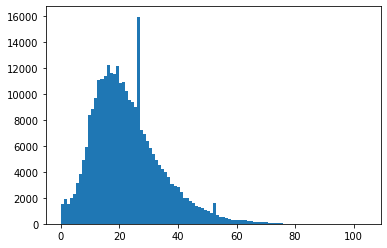

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()
plt.close()

In [41]:
np.argmax(lengths)

26105

In [42]:
np.argmin(lengths)

607

In [43]:
train_ori_src[26105]

'DreamWorks Animation has produced some of the highest grossing animated hits of all time , such as Antz -LRB-/O1998/O-RRB- , The Prince of Egypt -LRB-/O1998/O-RRB- , Shrek -LRB-/O2001/O-RRB- , its sequels Shrek 2 -LRB-/O2004/O-RRB- , Shrek the Third -LRB-/O2007/O-RRB- and Shrek Forever After -LRB-/O2010/O-RRB- ; Shark Tale -LRB-/O2004/O-RRB- , Madagascar -LRB-/O2005/O-RRB- , Over the Hedge -LRB-/O2006/O-RRB- , Flushed Away -LRB-/O2006/O-RRB- , Bee Movie -LRB-/O2007/O-RRB- , Kung Fu Panda -LRB-/O2008/O-RRB- and How to Train Your Dragon -LRB-/O2010/O-RRB- .\n'

In [44]:
train_ori_src[607]

"! ''\n"

In [45]:
sentence_length = 60

In [46]:
train_x = np.array([encoder(tokenizer(line), tokenizer_src, sentence_length) for line in train_ori_src]).reshape(-1, sentence_length)

In [47]:
train_x.shape

(296402, 60)

In [48]:
lengths_dst = [len((tokenizer(x))) for x in train_ori_dst]

In [49]:
print("min", np.min(lengths_dst))
print("mean", np.mean(lengths_dst))
print("max", np.max(lengths_dst))
print("std", np.std(lengths_dst))

min 0
mean 16.679013636885042
max 80
std 10.492046320896975


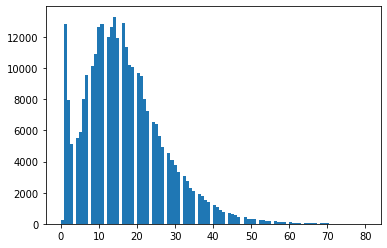

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths_dst, bins=100)
plt.show()
plt.close()

In [51]:
sentence_length_dst = 50

In [52]:
train_x.shape

(296402, 60)

### Look at output vocabulary

In [54]:
clean_txt_dst = clean(train_ori_dst)
token_list_dst = nltk.word_tokenize(clean_txt_dst)
len(set(token_list_dst))

301914

In [55]:
token_list_dst_Counter = collections.Counter(token_list_dst)
token_list_dst_Counter_desc = []
for key, value in token_list_dst_Counter.items():
    token_list_dst_Counter_desc.append((value, key))

In [56]:
token_list_dst_Counter = collections.Counter(token_list_dst)
embedding_size = 100 # GloVe 100d
threshold = 4
token_list_dst_over_threshold = [(count, word) for (count, word) in token_list_dst_Counter_desc if count > threshold ]
token_list_dst_over_threshold = sorted(token_list_dst_over_threshold, key=lambda x: x[0])
vocabulary_size_dst = len(token_list_dst_over_threshold) + 1
print(vocabulary_size_dst)
token_list_dst_over_threshold[:20]


34929


[(5, 'pomegranate'),
 (5, 'refineries'),
 (5, 'wastewater'),
 (5, 'scythe'),
 (5, 'italysome'),
 (5, 'pediapress'),
 (5, 'valentino'),
 (5, 'mantra'),
 (5, 'pst'),
 (5, 'predestination'),
 (5, 'waxy'),
 (5, 'solsticethe'),
 (5, 'barty'),
 (5, 'michener'),
 (5, 'statesevents'),
 (5, 'tokhtamysh'),
 (5, 'marilyns'),
 (5, 'connectivity'),
 (5, 'furius'),
 (5, 'camillus')]

In [57]:
improved_token_list_dst = improve_token_list([x[1] for x in token_list_dst_over_threshold])
improved_token_list_dst = list((set(improved_token_list_dst)))
vocabulary_size_dst = len(improved_token_list_dst) + 1
print(vocabulary_size_dst)

32119


In [58]:
tokenizer_dst = {}
i = 1
for word in improved_token_list_dst:
    tokenizer_dst[word] = i
    i += 1
tokenizer_dst["<UNK>"] = i
len(tokenizer_dst)

32119

In [59]:
train_y = np.array([encoder(tokenizer(line), tokenizer_dst, sentence_length_dst) for line in train_ori_dst]).reshape(-1, sentence_length_dst)

In [60]:
train_y.shape

(296402, 50)

In [61]:
import gc
gc.collect()

18494

In [62]:
divmod(5,3)

(1, 2)

In [67]:
def train_gen(data, b_size):
    n = data.shape[0]
    steps, rem = divmod(n, b_size)
    for i in range(steps):
        yield data[i*b_size:(i+1)*b_size]
    yield data[(i+1)*b_size:]

In [74]:
train_y_gen = train_gen(train_y, 500)

In [219]:
next(train_y_gen).shape


(500, 50)

In [115]:
number_samples = 
decoder_targets_one_hot = np.zeros((
        number_samples,
        sentence_length_dst,
        vocabulary_size_dst+1  # hm... why?
    ))
   

def one_hot_encode_output(encoded_sentences, vocab_size):
    for i, sentence in enumerate(encoded_sentences):
        for t, word in enumerate(sentence):
            decoder_targets_one_hot[i, t, word] = 1


In [212]:
train_y_gen = train_gen(train_y, 500)
def one_hot_encode_output(encoded_sentences):      #, vocab_size):
    for curr in encoded_sentences:         #encoded_sentences
        number_samples = curr.shape[0]
        decoder_targets_one_hot = np.zeros((
                number_samples,
                sentence_length_dst,
                vocabulary_size_dst+1  # hm... why?
            ))
        for i, sentence in enumerate(curr):
            for t, word in enumerate(sentence):
                decoder_targets_one_hot[i, t, word] = 1
        yield decoder_targets_one_hot

In [63]:
def one_hot_encode_output(encoded_sentences, b_size):
    n = encoded_sentences.shape[0]
    steps = n / b_size
    i = 0
    if i < steps:
        curr = encoded_sentences[i*b_size:(i+1)*b_size]
    else:
        curr = encoded_sentences[(i+1)*b_size:]
    
    number_samples = curr.shape[0]
    decoder_targets_one_hot = np.zeros((
            number_samples,
            sentence_length_dst,
            vocabulary_size_dst+1  # hm... why?
        ))
    for i, sentence in enumerate(curr):
        for t, word in enumerate(sentence):
            decoder_targets_one_hot[i, t, word] = 1
    i += 1
    yield decoder_targets_one_hot

In [73]:
hm = one_hot_encode_output(train_y_gen)

In [72]:
# count = 0
# while count < 1e6:
#     next(hm).shape
#     count += 1
print(count)

593


In [220]:
593*500

296500

In [81]:
train_x_gen = train_gen(train_x, 500)

In [219]:
# one hot encode target sequence
def one_hot_encode_output(encoded_sentences, vocab_size):
    ylist = list()
    for i in range(encoded_sentences.shape[0]):
        sequence = encoded_sentences[i]
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(encoded_sequences.shape[0], encoded_sequences.shape[1], vocab_size)
    return y

In [161]:
train_y = one_hot_encode_output(train_y[:1000], vocabulary_size_dst+1 )

NameError: name 'to_categorical' is not defined

In [87]:
def a():
    for i in range(10):
        yield i
def b():
    for i in range(10):
        yield 2*i


In [201]:
a1 = a()
b1 = b()
def c():
    for a2, b2 in zip(a1, b1):
        yield (a2, b2)

In [202]:
c1 = zip(a1, b1)

In [205]:
next(c1)

(2, 4)

In [206]:
data_gen = zip(train_x_gen, one_hot_encode_output(train_y_gen))

In [266]:
def generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while 1:

        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])#.astype('float32')
        y_batch = one_hot_encode_output(y_batch)
        counter += 1
        yield X_batch,y_batch

        #restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            counter = 0

In [267]:
train_x.shape[0]

296402

In [268]:
decoder_targets_one_hot[1, 3, 943]

0.0

In [269]:
decoder_targets_one_hot = np.zeros((
            50,
            sentence_length_dst,
            vocabulary_size_dst+1  # hm... why?
        ))

In [275]:
def one_hot_encode_output(encoded_sentences):      #, vocab_size):
    curr = encoded_sentences        #encoded_sentences
    number_samples = curr.shape[0]
    decoder_targets_one_hot = np.zeros((
            number_samples,
            sentence_length_dst,
            vocabulary_size_dst+1  # hm... why?
        ))
    for i, sentence in enumerate(curr):
        for t, word in enumerate(sentence):
            decoder_targets_one_hot[i, t, word] = 1
    return decoder_targets_one_hot

In [276]:
from tensorflow.keras import models, layers, callbacks
import datetime
#import tensorboard

model = models.Sequential()
model.add(layers.Embedding(          #word embedding
    vocabulary_size_source,
    embedding_size,
    input_length=sentence_length

))
model.add(layers.LSTM(embedding_size))
model.add(layers.RepeatVector(sentence_length_dst))
model.add(layers.LSTM(embedding_size, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(vocabulary_size_dst+1, activation='softmax')))


model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False   #freeze

model.summary()



model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics=["accuracy"]

)
batch_size = 50
history = model.fit_generator(
    generator(train_x, train_y, batch_size),
    #data_gen,
    #(train_gen(train_x, 500), one_hot_encode_output(train_y_gen)),
    epochs=10,
    #batch_size=50,
    #validation_split=0.2,
    steps_per_epoch = train_x.shape[0]/batch_size,
    

)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 60, 100)           4212000   
_________________________________________________________________
lstm_38 (LSTM)               (None, 100)               80400     
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 50, 100)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 50, 32120)         3244120   
Total params: 7,616,920
Trainable params: 3,404,920
Non-trainable params: 4,212,000
_________________________________________________________________
Epoch 1/10
5929/5928 [==============================] - 15239s 3s/step - loss: 2.7005
Epoch 2/10
1587

KeyboardInterrupt: 